# Visualise the data in the 2022 March - April Floods
## Make plots of the data in a selected AOI

Flooding period according to Wikipedia [[LINK](https://en.wikipedia.org/wiki/2022_eastern_Australia_floods)]:
 
 * 2022-02-23 to 2022-03-27 ... first event.
 * 2022-03-28 to 2022-04-10 ... second event.
 
 
However, the NRRA want to treat both events as one: 
 
 * 2022-02-23 to 2022-04-10 ... combined date bounds of early 2022 Australian Floods.
 

In [3]:
# Necessary imports
import os
from itertools import product
from math import ceil
from datetime import datetime
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from ml4floods.data import utils
from ml4floods.visualization import plot_utils
from ml4floods.data.ee_download import process_metadata
from ml4floods.models import postprocess

In [4]:
# Access parameters for the ML4CC bucket
key_json = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/ml4cc-general-access_request_pays.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_json
os.environ["GS_USER_PROJECT"] = "ml4cc-general"

In [5]:
# Path to the working folder on Google Cloud
path_to_aois = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/"

In [6]:
# Flooding start and end dates
flooding_date_pre = "2022-02-20"   # Days before this date are dry
flooding_date_start= "2022-02-23"  # Flooding start
flooding_date_end = "2022-04-10"   # Flooding end

In [7]:
# Convert dates to usable format
flooding_date_pre_dt = datetime.strptime(flooding_date_pre, "%Y-%m-%d")
flooding_date_start_dt = datetime.strptime(flooding_date_start, "%Y-%m-%d")
flooding_date_end_dt = datetime.strptime(flooding_date_end, "%Y-%m-%d")

# Get a filesystem refererence to the Google Bucket
fs = utils.get_filesystem(path_to_aois)

## Query the available data for the AOI and parse the metadata

Metadata is generated by the downloader and contains fractional cloud cover and data availability

In [8]:
# Selected AOI
aoi = "AUTOAOI144"

In [9]:
# Query the GEOJSONS written to the model directory unde the AOI
geojsons = [f"gs://{f}" for f in fs.glob(f"{path_to_aois}{aoi}/WF2_unet_rbgiswirs_vec/*/*.geojson")]

# Function generate a <date><Satellite> key for sorting purposes.
# Sentinel-2 is sorted first by preference.
def key_sort(x):
    date = os.path.splitext(os.path.basename(x))[0]
    satellite = os.path.basename(os.path.dirname(x))
    if satellite == "Landsat":
        append = "B"
    else:
        append = "A"
    return date + append

# Sort the predictions by date and satellite
geojsons.sort(key=key_sort)
print(f"Found {len(geojsons)} predicted water maps by date for {aoi}.")

Found 11 predicted water maps by date for AUTOAOI144.


In [10]:
# Generate a table of metadata for the Landsat images from CSV file written by downloader.
# Contains: cloud_probability, date-stamp, filename and file availability.
metadata_s2 = process_metadata(f"{path_to_aois}{aoi}/S2/s2info.csv")
metadata_s2["satellite"] = "S2"
metadata_l89 = process_metadata(f"{path_to_aois}{aoi}/Landsat/landsatinfo.csv")
metadata_l89["satellite"] = "Landsat"
metadata = pd.concat([metadata_s2, metadata_l89],ignore_index=True)
metadata.cloud_probability*=100
metadata = metadata[metadata["valids"] >= .8]
print(f"There are {metadata.shape[0]} entries in the table.")
metadata

There are 23 entries in the table.


system:time_start  valids  cloud_probability  \
0        1.643415e+12     1.0          99.895274   
1        1.643847e+12     1.0          18.019205   
2        1.644279e+12     1.0          95.578822   
3        1.644711e+12     1.0           1.243976   
4        1.645143e+12     1.0          61.100483   
5        1.645575e+12     1.0          89.149152   
6        1.646007e+12     1.0          86.545272   
7        1.646439e+12     1.0          99.514385   
8        1.646871e+12     1.0          73.229856   
9        1.647303e+12     1.0          99.651179   
10       1.647735e+12     1.0           2.023789   
11       1.648167e+12     1.0          43.522251   
12       1.648599e+12     1.0          67.118932   
13       1.649031e+12     1.0          86.332294   
19       1.642809e+12     1.0          62.666732   
20       1.644191e+12     1.0          88.037534   
21       1.645574e+12     1.0          84.708088   
22       1.646956e+12     1.0           0.000000   
23       1.648339e+12     1.0          47.697037   
28       1.644883e+12     1.0           0.315292   
30       1.649030e+12     1.0          74.590618   
31       1.642118e+12     1.0          84.435135   
32       1.647647e+12     1.0          96.485722   

                           datetime  index_image_collection  names2file  \
0  2022-01-29 00:07:03.378500+00:00                       0  2022-01-29   
1  2022-02-03 00:06:57.584500+00:00                       1  2022-02-03   
2  2022-02-08 00:07:02.593000+00:00                       2  2022-02-08   
3  2022-02-13 00:06:57.280500+00:00                       3  2022-02-13   
4  2022-02-18 00:07:04.417000+00:00                       4  2022-02-18   
5  2022-02-23 00:06:58.268000+00:00                       5  2022-02-23   
6  2022-02-28 00:07:06.436500+00:00                       6  2022-02-28   
7  2022-03-05 00:07:00.473000+00:00                       7  2022-03-05   
8  2022-03-10 00:07:07.322000+00:00                       8  2022-03-10   
9  2022-03-15 00:07:01.342500+00:00                       9  2022-03-15   
10 2022-03-20 00:07:06.754000+00:00                      10  2022-03-20   
11 2022-03-25 00:07:00.779000+00:00                      11  2022-03-25   
12 2022-03-30 00:06:59.128000+00:00                      12  2022-03-30   
13 2022-04-04 00:07:00.036000+00:00                      13  2022-04-04   
19 2022-01-21 23:51:04.806000+00:00                       5  2022-01-21   
20 2022-02-06 23:51:01.283000+00:00                       6  2022-02-06   
21 2022-02-22 23:50:55.549500+00:00                       7  2022-02-22   
22 2022-03-10 23:50:52.162500+00:00                       8  2022-03-10   
23 2022-03-26 23:50:40.697500+00:00                       9  2022-03-26   
28 2022-02-14 23:51:05.928000+00:00                      14  2022-02-14   
30 2022-04-03 23:50:50.264000+00:00                      16  2022-04-03   
31 2022-01-13 23:51:19.669000+00:00                      17  2022-01-13   
32 2022-03-18 23:50:53.937000+00:00                      18  2022-03-18   

    s2available satellite  
0         False        S2  
1         False        S2  
2         False        S2  
3          True        S2  
4         False        S2  
5         False        S2  
6         False        S2  
7         False        S2  
8          True        S2  
9         False        S2  
10         True        S2  
11         True        S2  
12         True        S2  
13         True        S2  
19        False   Landsat  
20        False   Landsat  
21        False   Landsat  
22         True   Landsat  
23         True   Landsat  
28         True   Landsat  
30         True   Landsat  
31        False   Landsat  
32        False   Landsat

## Visualise the data availability and cloud cover

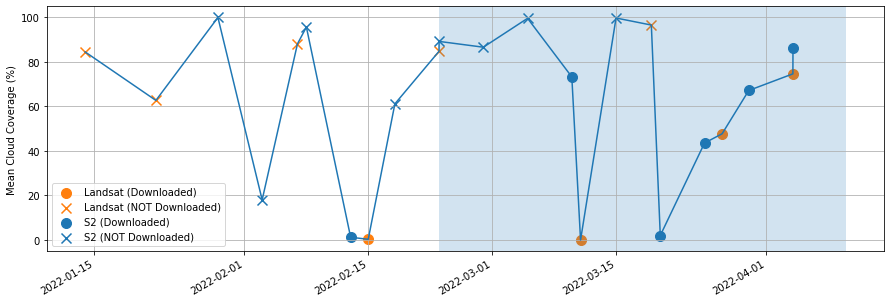

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15,5))


# Loop through the combination of <satellite><downloaded|not-downloaded>.
# Plot % cloud versus date for each combination.
for sat, downloaded in product(["Landsat","S2"], [True, False]):
    label=f"{sat} ({'' if downloaded else 'NOT '}Downloaded)"
    selection_mask = (metadata.satellite == sat) & (metadata.s2available == downloaded)
    color = "C0" if sat =="S2" else "C1"
    marker = "o" if downloaded else "x"
    ax.scatter(x=metadata[selection_mask].datetime, 
               y=metadata[selection_mask].cloud_probability, 
               label=label, c=color, marker=marker, s=100)

# Format plot to look nice.
ax.legend()
metadata.plot(x="datetime", y="cloud_probability", ax=ax,legend=None)
ax.axvspan(flooding_date_start_dt, flooding_date_end_dt, alpha=0.2)
plt.ylabel("Mean Cloud Coverage (%)")
plt.xlabel("")
plt.grid()

## Plot the downloaded images

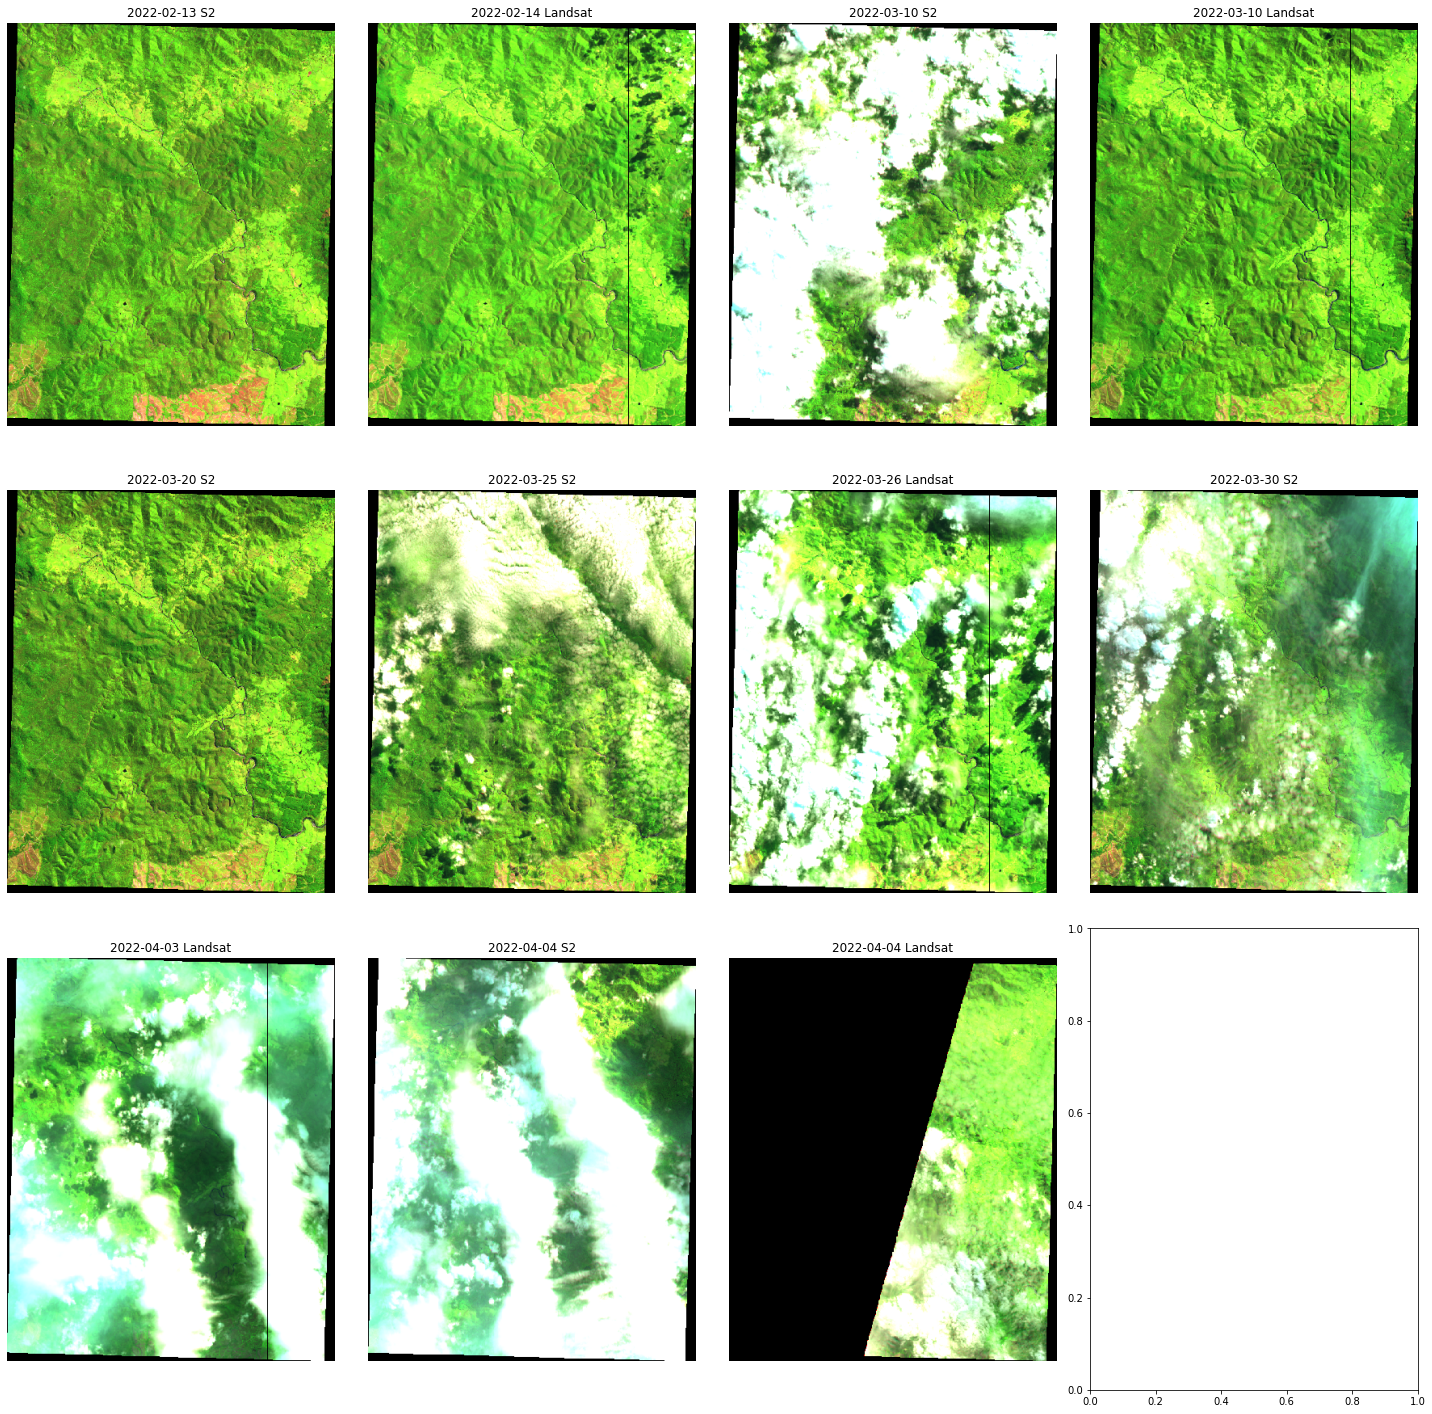

In [13]:
# Set layout of plot grid
num_images = len(geojsons)
n_cols = 4
n_rows = ceil(len(geojsons) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,20),tight_layout=True)
ax = ax.flatten()

for idx, g in enumerate(geojsons):
    
    # Parse the GEOJSON path (prediction) construct the raw data path 
    date = os.path.splitext(os.path.basename(g))[0]
    satellite_dir = os.path.dirname(g)
    satellite = os.path.basename(satellite_dir)
    aoi_dir = os.path.dirname(os.path.dirname(satellite_dir))
    geotiff = os.path.join(aoi_dir, satellite, f"{date}.tif")
    
    # Plot bands B11, B8, B4 of a Sentinel-2 image
    plot_utils.plot_swirnirred_image(geotiff, ax=ax[idx], size_read=500, collection_name=satellite)
    ax[idx].set_title(f"{date} {satellite}")
    ax[idx].axis("off")
    

## Plot the processed floodmaps for the same images

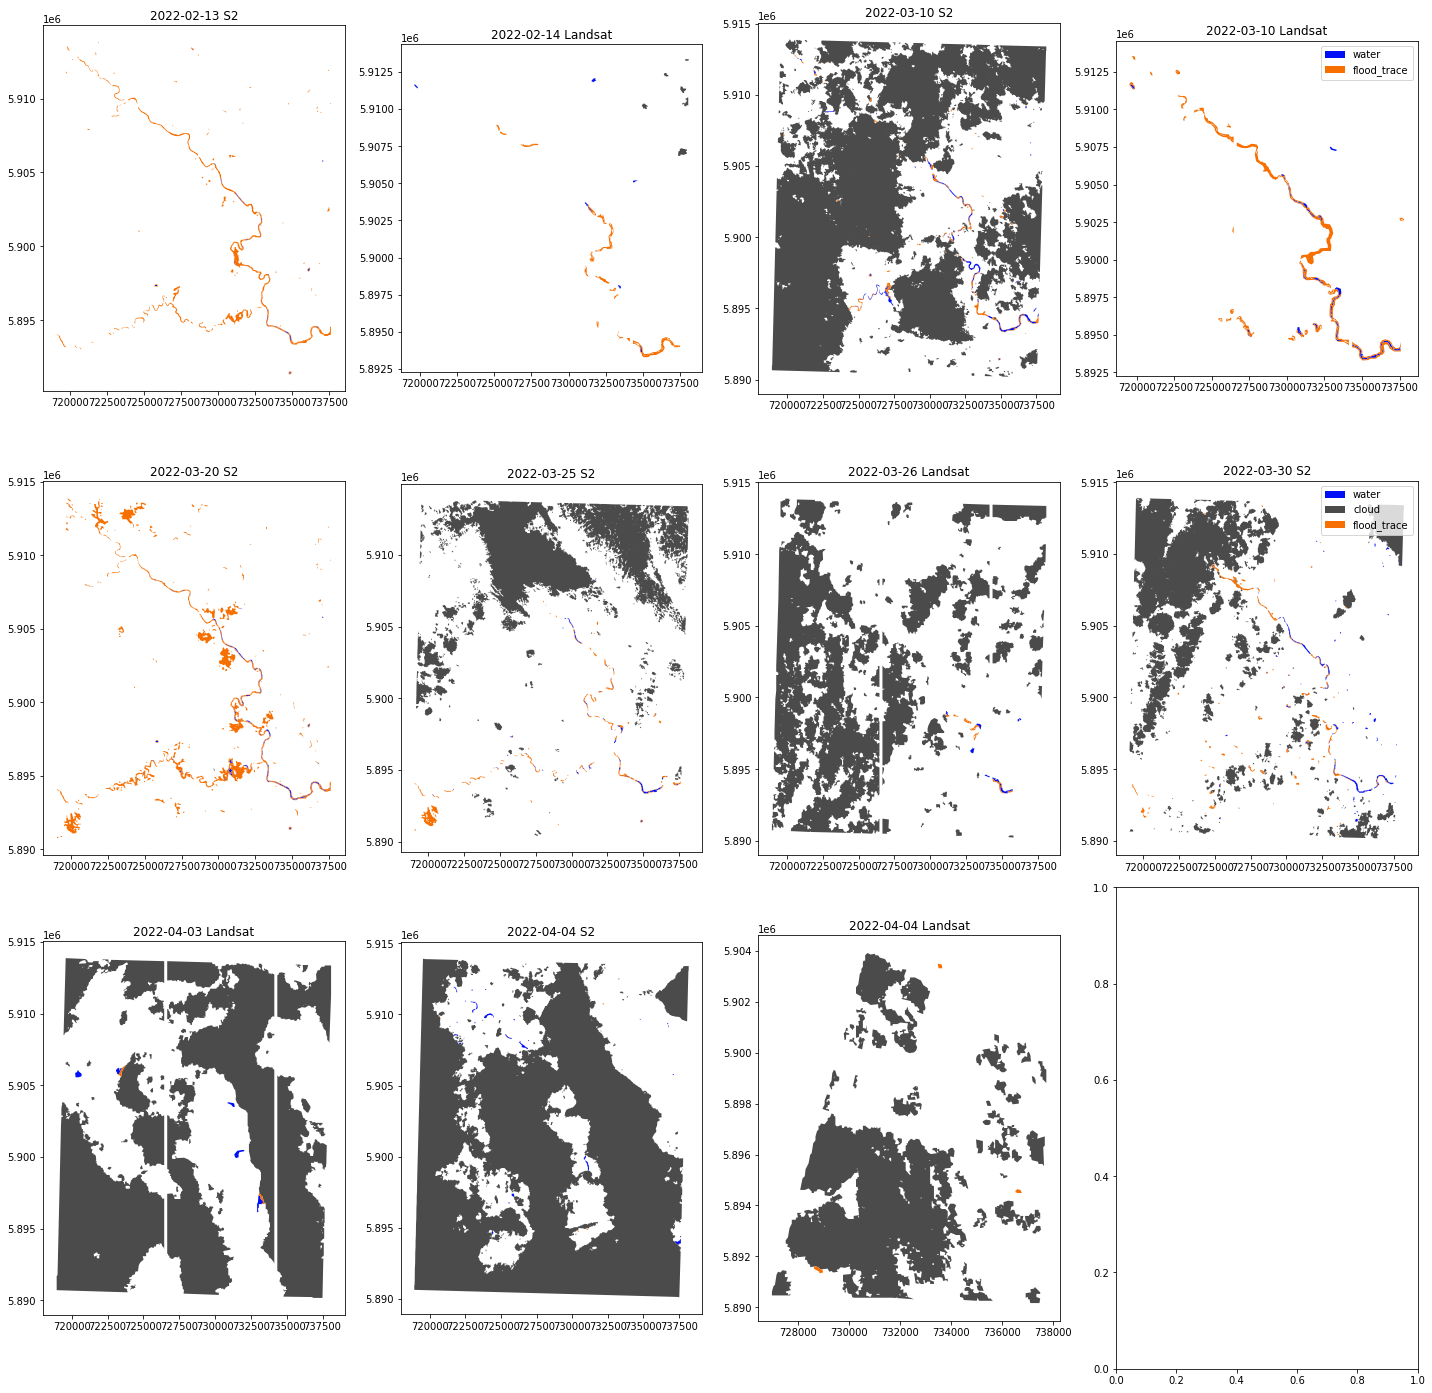

In [14]:
# Set the layout as previous
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,20),tight_layout=True)
ax = ax.flatten()

floodmaps = []
for idx,g in enumerate(geojsons):
    # Parse the GEOJSON path for date and satellite name
    date = os.path.splitext(os.path.basename(g))[0]
    satellite = os.path.basename(os.path.dirname(g))
    
    # Read the water prediction into a list and plot
    floodmap = utils.read_geojson_from_gcp(g)
    floodmaps.append(floodmap)
    plot_utils.plot_floodmap(floodmap, ax=ax[idx], legend=(idx%n_cols)==n_cols-1)
    ax[idx].set_title(f"{date} {satellite}")

Here we can see the first two maps are pre-flood and show the normal water extent. Maps 4 and 5 show the flooding well.

## Fetch and plot the pre-flood water masks

In [15]:
# Filter for water maps before the event
floodmaps_pre = [g for g in geojsons if os.path.splitext(os.path.basename(g))[0] < flooding_date_pre]
print(f"Floodmaps to process before the flooding:")
for g in floodmaps_pre:
    print(os.path.basename(g))

Floodmaps to process before the flooding:
2022-02-13.geojson
2022-02-14.geojson


In [16]:
# Fetch a geodataframe with all water polygons in these two 
data_pre = postprocess.get_floodmap_pre(floodmaps_pre,verbose=True)
print(f"There are {len(data_pre)} polygons.")
data_pre.head()

All area is covered in idx 1. Area missing empty: True Geom type: Polygon
There are 35 polygons.


class                                           geometry
0  water  POLYGON ((725900.000 5897340.000, 725900.000 5...
1  water  POLYGON ((732090.000 5898660.000, 732060.000 5...
2  water  POLYGON ((731180.000 5898840.000, 731180.000 5...
3  water  POLYGON ((731160.000 5899320.000, 731160.000 5...
4  water  POLYGON ((731120.000 5899340.000, 731100.000 5...

<AxesSubplot:>

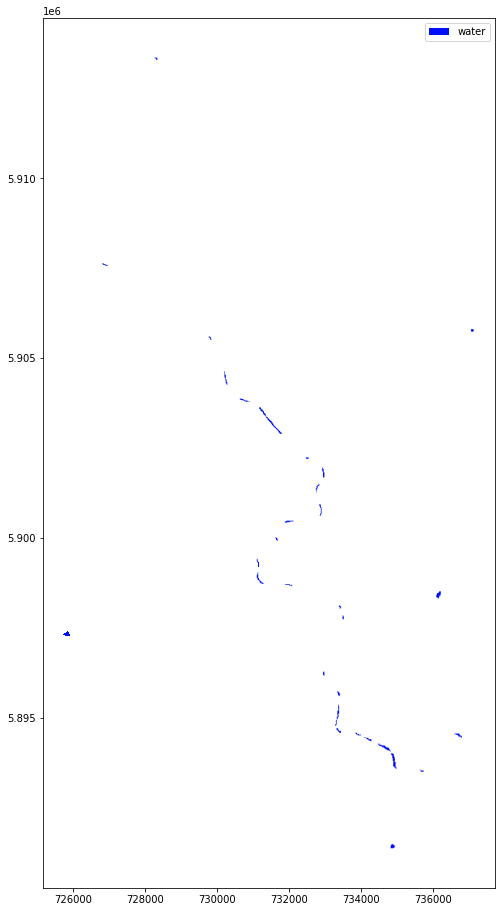

In [18]:
# Plot all the pre-flood polygons
plot_utils.plot_floodmap(data_pre, figsize=(16,16))

## Fetch and plot the flood mask

In [19]:
# Filter for water maps after the start of the event
floodmaps_post = [g for g in geojsons 
                  if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_start) 
                  and (os.path.splitext(os.path.basename(g))[0] < flooding_date_end)]
print(f"Floodmaps to process after the flooding event:")
for g in floodmaps_post:
    print(os.path.basename(g))

Floodmaps to process after the flooding event:
2022-03-10.geojson
2022-03-10.geojson
2022-03-20.geojson
2022-03-25.geojson
2022-03-26.geojson
2022-03-30.geojson
2022-04-03.geojson
2022-04-04.geojson
2022-04-04.geojson


In [26]:
# Fetch a geodataframe with all water polygons in these maps
data_post = postprocess.get_floodmap_post(floodmaps_post,verbose=True)
print(f"There are {len(data_pre)} polygons.")
data_post.head()

All area is covered in idx 3. Area missing empty: True Geom type: Polygon
There are 35 polygons.


class                                           geometry
0  flood_trace  POLYGON ((719008.176 5894078.637, 719039.659 5...
1  flood_trace  POLYGON ((725340.000 5895680.000, 725360.000 5...
2  flood_trace  POLYGON ((725780.000 5895680.000, 725760.000 5...
3  flood_trace  POLYGON ((725960.000 5895960.000, 725940.000 5...
4  flood_trace  POLYGON ((726220.000 5895950.000, 726140.000 5...

<AxesSubplot:>

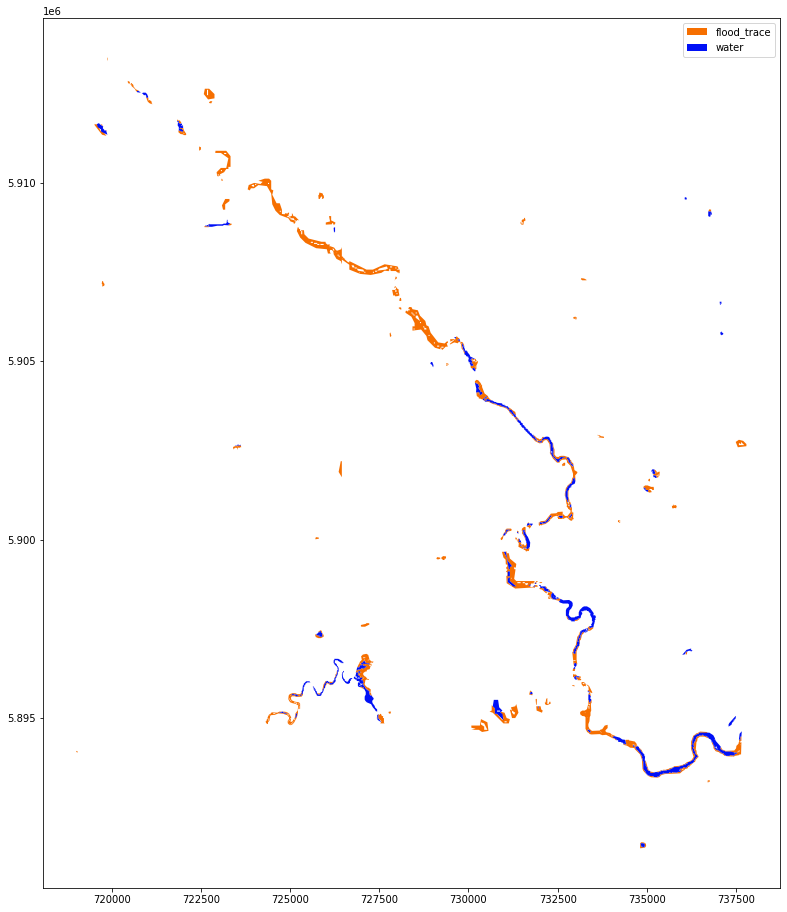

In [27]:
# Plot all the post-flood polygons
plot_utils.plot_floodmap(data_post, figsize=(16,16))